# Connect to google account

In [ ]:
# 구글 드라이브 연결
from google.colab import drive
drive.mount("/content/data")

Drive already mounted at /content/data; to attempt to forcibly remount, call drive.mount("/content/data", force_remount=True).


In [ ]:
!pip install category_encoders

In [ ]:
# 모듈 Import
import random
import numpy as np # 행렬 계산에 사용하는 모듈
import pandas as pd # 데이터 처리와 분석을 위한 모듈
import matplotlib.pyplot as plt # 데이터 시각화를 위한 모듈. 2D, 3D 그릴 때 사용
import seaborn as sns # 데이터 시각화를 위한 모듈. 두 데이터의 관계를 볼때 사용

import category_encoders as ce

from datetime import datetime, timedelta
from tqdm.auto import tqdm

import warnings
# FutureWarning 경고를 무시하도록 설정
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# 딕셔너리를 간편하게 사용하는 것을 도와준다. 모델 class 처럼 사용 가능
# dot을 이용해 객체를 불러 사용. JSON 다룰때 유용.
import easydict
args = easydict.EasyDict()

# path
args.default_path = "/content/data/MyDrive/플레이데이터 데이터엔지니어링 28기/Dacon/KMU/data/" # 메인 경로
args.apply_train_path = args.default_path + "apply_train.csv" # train 데이터 경로
args.company_path = args.default_path + "company.csv"
args.recruitment_path = args.default_path + "recruitment.csv"
args.resume_certificate_path = args.default_path + "resume_certificate.csv"
args.resume_education_path = args.default_path + "resume_education.csv"
args.resume_language_path = args.default_path + "resume_language.csv"
args.resume_path = args.default_path + "resume.csv"

args.default_submission_path = args.default_path + "sample_submission.csv" # 예측결과(제출파일) 경로

# 데이터 분석을 위한 변수들
# # 난수 생성 제어 => 같은 코드를 실행해도 동일한 결과를 얻기 위해서 설정
# 데이터 분할 및 모델 초기화 때 유용.
args.random_state = 42
args.results = [] # 결과 저장 리스트

In [ ]:
args.submission_path = args.default_path + "result/submission_20231108.csv" # 결과 저장 파일
args.save_results = args.default_path+"result/model_results_20231108.json" # 결과 저장 json

In [ ]:
def recall5(answer_df, submission_df):

    primary_col = answer_df.columns[0]
    secondary_col = answer_df.columns[1]

    # submission의 예측이 각각 5개인지 확인
    prediction_counts = submission_df.groupby(primary_col).size()
    if not all(prediction_counts == 5):
        raise ValueError(f"Each {primary_col} should have exactly 5 {secondary_col} predictions.")


    # submission의 예측된 값들에 null값이 있는지 확인
    if submission_df[secondary_col].isnull().any():
        raise ValueError(f"Predicted {secondary_col} contains NULL values.")

    # 예측값에 중복이 있는지 확인
    duplicated_preds = submission_df.groupby(primary_col).apply(lambda x: x[secondary_col].duplicated().any())
    if duplicated_preds.any():
        raise ValueError(f"Predicted {secondary_col} contains duplicates for some {primary_col}.")


    # Filter the submission dataframe based on the primary_col present in the answer dataframe
    # primary_col 즉 resume_seq가 양측에 있는지 확인 후 남김
    submission_df = submission_df[submission_df[primary_col].isin(answer_df[primary_col])]

    # For each primary_col, get the top 5 predicted secondary_col values
    #
    top_5_preds = submission_df.groupby(primary_col).apply(lambda x: x[secondary_col].head(5).tolist()).to_dict()

    # Convert the answer_df to a dictionary for easier lookup
    true_dict = answer_df.groupby(primary_col).apply(lambda x: x[secondary_col].tolist()).to_dict()


    individual_recalls = []
    for key, val in true_dict.items():
        if key in top_5_preds:
            correct_matches = len(set(true_dict[key]) & set(top_5_preds[key]))
            individual_recall = correct_matches / min(len(val), 5) # 공정한 평가를 가능하게 위하여 분모(k)를 'min(len(val), 5)' 로 설정함
            individual_recalls.append(individual_recall)


    #recall = np.mean(individual_recalls)
    recall = max(individual_recalls)
    return recall

# File Load

In [ ]:
apply_train_df = pd.read_csv(args.apply_train_path) # apply_train -> DataFrame화
company_df = pd.read_csv(args.company_path) # company -> DataFrame화
recruitment_df = pd.read_csv(args.recruitment_path) # recruitment -> DataFrame화
resume_certificate_df = pd.read_csv(args.resume_certificate_path) # resume_certificate -> DataFreame화
resume_education_df = pd.read_csv(args.resume_education_path) # resume_education -> DataFrame화
resume_language_df = pd.read_csv(args.resume_language_path) # resume_language -> DataFrame화
resume_df = pd.read_csv(args.resume_path) # resume -> DataFrame화
submission_df = pd.read_csv(args.default_submission_path)

In [ ]:
apply_train = apply_train_df.copy()
company = company_df.copy()
recruitment = recruitment_df.copy()
resume_certificate = resume_certificate_df.copy()
resume_education = resume_education_df.copy()
resume_language = resume_language_df.copy()
resume = resume_df.copy()


### merged_recruitment 생성

In [ ]:
# recruitment, company 정렬(recruitment_seq 기준)
company = company.sort_values(by = "recruitment_seq")
recruitment = recruitment.sort_values(by = "recruitment_seq")

In [ ]:
# merged_recruitment = recruitment, company merge
merged_recruitment = pd.merge(recruitment, company, on='recruitment_seq', how='left')
merged_recruitment

,recruitment_seq,address_seq1,address_seq2,address_seq3,career_end,career_start,check_box_keyword,education,major_task,qualifications,text_keyword,company_type_seq,supply_kind,employee
0,R00001,5.0,NaN,NaN,0,0,2101;2108;2201;2204;2205;2707;2810,2,2,1,NaN,5.0,201.0,631.0
1,R00002,3.0,NaN,NaN,0,0,2507;2703;2707,3,2,1,NaN,2.0,201.0,160.0
2,R00003,3.0,NaN,NaN,0,0,2101;2108;2201;2707,3,2,2,NaN,NaN,NaN,NaN
3,R00004,3.0,NaN,NaN,0,0,2507;2707,3,2,1,NaN,2.0,402.0,500.0
4,R00005,3.0,NaN,NaN,0,0,2507;2707,3,2,1,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6690,R06691,3.0,NaN,NaN,0,0,2501;2507;2707,3,2,1,NaN,NaN,NaN,NaN
6691,R06692,3.0,NaN,NaN,0,0,2201;2507,3,2,2,NaN,4.0,402.0,150.0
6692,R06693,5.0,NaN,NaN,0,0,2102;2707,4,2,1,NaN,NaN,NaN,NaN
6693,R06694,3.0,NaN,NaN,0,0,2101;2108;2109;2110;2201;2203;2707,4,2,1,NaN,NaN,NaN,NaN


### merged_resume 생성

In [ ]:
# resume 정렬 (resume_seq 기준)
resume = resume.sort_values(by='resume_seq')

In [ ]:
# resume_certificate 정렬 (resume_seq 기준)
resume_certificate = resume_certificate.sort_values(by='resume_seq')
# certificate_contents에 결측값이 존재하는 행 제거
resume_certificate = resume_certificate.dropna(subset=['certificate_contents'])
# 이력서번호(resume_seq)기준으로 groupby
# 이력서번호(resume_seq)의 해당하는 자격증들을 세미콜론(;)으로 join해서 적용(apply)
resume_certificate = resume_certificate.groupby('resume_seq')['certificate_contents'].apply(';'.join).reset_index()

In [ ]:
# resume_education 정렬 (resume_seq 기준)
resume_education = resume_education.sort_values(by='resume_seq')

In [ ]:
# resume_language 정렬 (resume_seq 기준)
resume_language = resume_language.sort_values(by='resume_seq')

In [ ]:
# merged_resume = resume, resume_certificate, resume_education, resume_language
merged_resume = pd.merge(resume, resume_certificate, on='resume_seq', how='left')
merged_resume = pd.merge(merged_resume, resume_education, on='resume_seq', how='left')
merged_resume = pd.merge(merged_resume, resume_language, on='resume_seq', how='left')
merged_resume

,resume_seq,reg_date,updated_date,degree,graduate_date,hope_salary,last_salary,text_keyword,job_code_seq1,job_code_seq2,...,univ_type_seq2,univ_transfer,univ_location,univ_major,univ_sub_major,univ_major_type,univ_score,language,exam_name,score
0,U00001,2019-12-27,2020-02-01,4,2009,1500.0,1500.0,디자이너,재료·화학·섬유·의복,NaN,...,5,0,17,NaN,NaN,9,20.0,NaN,NaN,NaN
1,U00002,2020-04-24,2020-04-29,4,2005,0.0,0.0,디자이너,재료·화학·섬유·의복,NaN,...,5,0,3,NaN,NaN,8,90.0,NaN,NaN,NaN
2,U00003,2018-02-14,2020-07-08,4,2004,0.0,0.0,남성복디자이너;TD캐주얼,재료·화학·섬유·의복,NaN,...,5,0,17,NaN,NaN,4,90.0,NaN,NaN,NaN
3,U00004,2017-10-26,2020-04-27,4,2011,0.0,0.0,상품기획;영업기획,재료·화학·섬유·의복,NaN,...,5,0,5,NaN,NaN,3,70.0,2.0,11.0,661.62
4,U00005,2020-03-18,2020-04-08,4,2011,0.0,0.0,인사;총무;경영;MD;상품기획,재료·화학·섬유·의복,NaN,...,0,0,0,NaN,NaN,10,50.0,2.0,4.0,873.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8526,U08478,2020-02-05,2020-03-31,4,2003,0.0,2700.0,상품기획,재료·화학·섬유·의복,NaN,...,5,0,5,NaN,NaN,19,0.0,NaN,NaN,NaN
8527,U08479,2016-02-17,2020-07-15,3,0,2500.0,2300.0,디자이너,재료·화학·섬유·의복,NaN,...,6,0,3,가정과,NaN,9,0.0,NaN,NaN,NaN
8528,U08480,2019-11-13,2020-06-24,4,0,0.0,0.0,VMD;텍스타일디자인;섬유디자인;니트디자인;여성복디자인,디자인,NaN,...,5,0,10,미술대학섬유패션코디네이션학과,NaN,9,80.0,NaN,NaN,NaN
8529,U08481,2020-07-09,2020-11-23,4,2015,0.0,2700.0,상품기획;머천다이저;기획MD,재료·화학·섬유·의복,NaN,...,5,0,5,NaN,NaN,9,60.0,NaN,NaN,NaN


### merged_total 생성

In [ ]:
_merged_total = pd.merge(apply_train, merged_recruitment, left_on='recruitment_seq', right_on='recruitment_seq', how='left')
_merged_total = pd.merge(_merged_total, merged_resume, left_on='resume_seq', right_on='resume_seq', how='left')
merged_total = _merged_total
merged_total.head()

,resume_seq,recruitment_seq,address_seq1,address_seq2,address_seq3,career_end,career_start,check_box_keyword,education,major_task,...,univ_type_seq2,univ_transfer,univ_location,univ_major,univ_sub_major,univ_major_type,univ_score,language,exam_name,score
0,U05833,R03838,3.0,NaN,NaN,0,0,2110;2203;2204;2299,3,2,...,5,0,3,NaN,NaN,3,60.0,NaN,NaN,NaN
1,U06456,R02144,3.0,NaN,NaN,0,0,2204;2507;2707,3,2,...,5,0,10,국어국문학과,NaN,8,70.0,NaN,NaN,NaN
2,U07807,R01877,3.0,NaN,NaN,0,0,2507;2707,3,2,...,5,0,15,NaN,NaN,4,80.0,NaN,NaN,NaN
3,U04842,R02463,3.0,NaN,NaN,0,0,2507;2707,4,2,...,5,0,3,NaN,NaN,9,80.0,NaN,NaN,NaN
4,U08336,R00112,3.0,NaN,NaN,0,0,2507;2707,3,8,...,5,0,17,NaN,NaN,9,70.0,NaN,NaN,NaN


In [ ]:
merged_total.isnull().sum() / len(merged_total)

resume_seq               0.000000
recruitment_seq          0.000000
address_seq1             0.000103
address_seq2             0.984885
address_seq3             0.998746
career_end               0.000000
career_start             0.000000
check_box_keyword        0.000000
education                0.000000
major_task               0.000000
qualifications           0.000000
text_keyword_x           0.902954
company_type_seq         0.654294
supply_kind              0.654294
employee                 0.654294
reg_date                 0.000000
updated_date             0.000000
degree                   0.000000
graduate_date            0.000000
hope_salary              0.000000
last_salary              0.000000
text_keyword_y           0.020989
job_code_seq1            0.000000
job_code_seq2            0.949450
job_code_seq3            0.980557
career_month             0.000000
career_job_code          0.058622
certificate_contents     0.270715
hischool_type_seq        0.000000
hischool_speci

# New_apply_train 조건 탐색

## 조건 1. Education / Degree

In [ ]:
merged_total.shape

(58220, 44)

In [ ]:
merged_total.groupby('education')['degree'].value_counts(ascending=False)

education  degree
2          4         12682
           3          1021
           5           530
           2           516
           6            17
3          4         21016
           3          1602
           5           847
           2           728
           6            19
4          4         17018
           3           913
           5           838
           2           447
           6            15
6          4             9
           3             1
           5             1
Name: degree, dtype: int64

In [ ]:
merged_total.groupby('degree')['education'].value_counts(ascending=False)

degree  education
2       3              728
        2              516
        4              447
3       3             1602
        2             1021
        4              913
        6                1
4       3            21016
        4            17018
        2            12682
        6                9
5       3              847
        4              838
        2              530
        6                1
6       3               19
        2               17
        4               15
Name: education, dtype: int64

In [ ]:
#요구학위보다 최종학위가 높은 경우
merged_total.loc[merged_total['education'] > merged_total['degree']].shape

(2099, 44)

In [ ]:
#학위를 두 수준이나 낮춰서 하향지원한 경우
##요구학위 > 최종학위가 높은 경우를 먼저 drop 하기 때문에 요구학위 < 최종학위인 경우만 생각하면 됨
###degree = 6인 지원자는 반드시 하향지원을 할 수 밖에없어서 예외처리
merged_total.loc[
    (merged_total['degree'] != 6)
    &
    (merged_total['degree'] - merged_total['education'] == 2)
    ].shape

(13529, 44)

In [ ]:
def drop_degree(df):
    # 'education' 컬럼 값이 'degree' 컬럼 값보다 큰 조건을 만족하는 행 삭제
    df.drop(df[df['education'] > df['degree']].index, inplace=True)
    #df.drop(df[(merged_total['degree'] != 6)
                #&
                #(merged_total['degree'] - merged_total['education'] == 2)
                #].index, inplace=True)
    return df

## 조건 2. 신입 / 경력

- 신입은 0, 경력은 1

In [ ]:
# 공고 기준으로 groupby해서 최종월급이 0인 지원자들(즉, 신입)이 많이 지원했다면 그 공고는 신입 포지션이었을 것이다.
# 신입 포지션이면 0, 경력 포지션이면 1
mode_career_month = merged_total.groupby('recruitment_seq')['last_salary'].agg(lambda x: x.mode().iloc[0]).reset_index()

# position 컬럼 생성
mode_career_month['position'] = mode_career_month['last_salary'].apply(lambda x: 1 if x != 0 else 0)

# 결과 확인
mode_career_month

,recruitment_seq,last_salary,position
0,R00001,4100.0,1
1,R00002,0.0,0
2,R00003,2300.0,1
3,R00004,0.0,0
4,R00005,2900.0,1
...,...,...,...
6690,R06691,0.0,0
6691,R06692,3300.0,1
6692,R06693,0.0,0
6693,R06694,0.0,0


In [ ]:
mode_career_month.drop('last_salary', axis=1, inplace=True)
merged_total = pd.merge(merged_total, mode_career_month, on='recruitment_seq', how='left')
merged_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58220 entries, 0 to 58219
Data columns (total 45 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   resume_seq             58220 non-null  object 
 1   recruitment_seq        58220 non-null  object 
 2   address_seq1           58214 non-null  float64
 3   address_seq2           880 non-null    float64
 4   address_seq3           73 non-null     float64
 5   career_end             58220 non-null  int64  
 6   career_start           58220 non-null  int64  
 7   check_box_keyword      58220 non-null  object 
 8   education              58220 non-null  int64  
 9   major_task             58220 non-null  int64  
 10  qualifications         58220 non-null  int64  
 11  text_keyword_x         5650 non-null   object 
 12  company_type_seq       20127 non-null  float64
 13  supply_kind            20127 non-null  float64
 14  employee               20127 non-null  float64
 15  re

In [ ]:
#경력 월이 12개월 미만이면(즉, 신입이면) 0, 아니면 1
merged_total['is_newbie'] = merged_total['career_month'].apply(lambda x: 0 if x < 12 else 1)
merged_total.head()

,resume_seq,recruitment_seq,address_seq1,address_seq2,address_seq3,career_end,career_start,check_box_keyword,education,major_task,...,univ_location,univ_major,univ_sub_major,univ_major_type,univ_score,language,exam_name,score,position,is_newbie
0,U05833,R03838,3.0,NaN,NaN,0,0,2110;2203;2204;2299,3,2,...,3,NaN,NaN,3,60.0,NaN,NaN,NaN,0,1
1,U06456,R02144,3.0,NaN,NaN,0,0,2204;2507;2707,3,2,...,10,국어국문학과,NaN,8,70.0,NaN,NaN,NaN,1,1
2,U07807,R01877,3.0,NaN,NaN,0,0,2507;2707,3,2,...,15,NaN,NaN,4,80.0,NaN,NaN,NaN,0,1
3,U04842,R02463,3.0,NaN,NaN,0,0,2507;2707,4,2,...,3,NaN,NaN,9,80.0,NaN,NaN,NaN,0,0
4,U08336,R00112,3.0,NaN,NaN,0,0,2507;2707,3,8,...,17,NaN,NaN,9,70.0,NaN,NaN,NaN,0,0


In [ ]:
#신입인데 경력포지션에 지원한 경우
merged_total[(merged_total['position'] == 1) & (merged_total['is_newbie'] == 0)].shape

(681, 46)

In [ ]:
#경력인데 신입포지션에 지원한 경우
merged_total[(merged_total['position'] == 0) & (merged_total['is_newbie'] == 1)].shape

(33055, 46)

왤캐 많지???????????????

In [ ]:
#경력인데 신입포지션에 지원한 경우가 많을 수 있다. 직무 전환일 경우..

In [ ]:
def drop_position(df):
    #신입인데 경력포지션에 지원한 경우 삭제
    df.drop(df[(df['position'] == 1) & (df['is_newbie'] == 0)].index, inplace=True)
    return df

## 조건 3. 주업무코드 != 희망직무

In [ ]:
merged_total['major_task'].unique()

array([ 2,  8,  7,  1,  9, 10,  6])

In [ ]:
df_task = merged_total[['resume_seq','recruitment_seq','major_task','job_code_seq1']]
df_task.head()

,resume_seq,recruitment_seq,major_task,job_code_seq1
0,U05833,R03838,2,재료·화학·섬유·의복
1,U06456,R02144,2,재료·화학·섬유·의복
2,U07807,R01877,2,재료·화학·섬유·의복
3,U04842,R02463,2,재료·화학·섬유·의복
4,U08336,R00112,8,재료·화학·섬유·의복


In [ ]:
job_code_mapping = {
    '재료·화학·섬유·의복': 1,
    '디자인': 2,
    '경영·기획·회계·사무': 3,
    '영업·판매·TM': 4,
    '건설·기계·전기·전자': 5,
    '전문·교육·자격':6,
    'IT·게임'                 :7,
    '기타 직종'                :8,
    '문화·예술·신문·방송'   :9
}

# job_code_seq1 열의 최빈값 찾기
most_frequent_value = df_task['job_code_seq1'].mode()[0]

# 최빈값을 사용하여 결측치 채우기
df_task['job_code_seq1'] = df_task['job_code_seq1'].fillna(most_frequent_value)
merged_total['job_code_seq1'] = merged_total['job_code_seq1'].fillna(most_frequent_value)

# 이후에 job_code_mapping을 사용하여 매핑
df_task['job_code_seq1'] = df_task['job_code_seq1'].map(job_code_mapping)
merged_total['job_code_seq1'] = merged_total['job_code_seq1'].map(job_code_mapping)

<ipython-input-101-25e25cf62663>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_task['job_code_seq1'] = df_task['job_code_seq1'].fillna(most_frequent_value)
<ipython-input-101-25e25cf62663>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_task['job_code_seq1'] = df_task['job_code_seq1'].map(job_code_mapping)


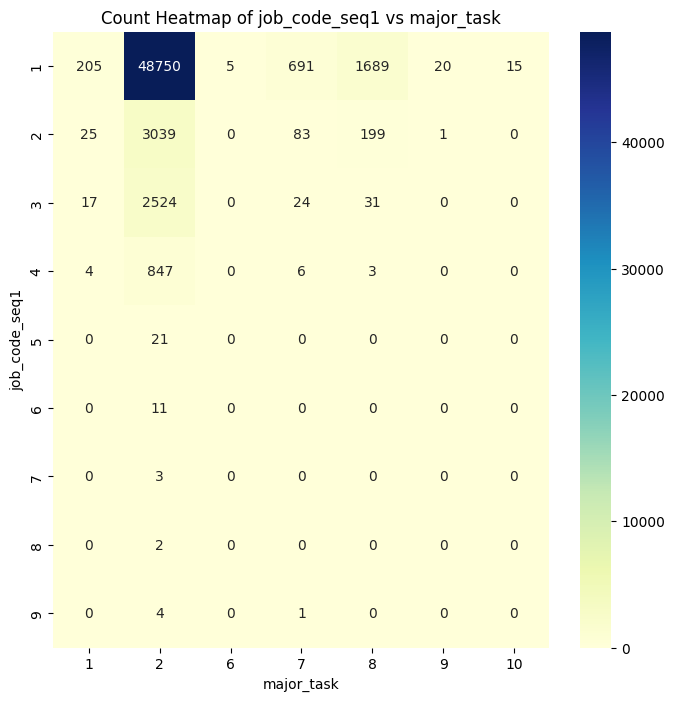

In [ ]:
# 두 컬럼의 조합별 빈도수 계산
count_matrix = pd.crosstab(merged_total['job_code_seq1'], merged_total['major_task'])

# 히트맵 그리기
plt.figure(figsize=(8, 8))  # 그래프 크기 조절
sns.heatmap(count_matrix, annot=True, fmt="d", cmap="YlGnBu")  # fmt="d"는 정수 형태로 주석을 달라는 의미
plt.title("Count Heatmap of job_code_seq1 vs major_task")
plt.ylabel("job_code_seq1")
plt.xlabel("major_task")
plt.show()

In [ ]:
#지원수가 적은 조합 10개만 날려보자..

combination_counts = pd.crosstab(merged_total['major_task'], merged_total['job_code_seq1'])

def drop_tasks(df, num_combinations=10):

    # 빈도수를 기반으로 조합 정렬 (낮은 순서), 상위 num_combinations 조합 가져오기
    lowest_combinations = combination_counts.stack().nsmallest(num_combinations).index

    # 낮은 조합의 행들을 제거
    for combination in lowest_combinations:
        major_task_value, job_code_seq1_value = combination
        df.drop(df[(df['major_task'] == major_task_value) & (df['job_code_seq1'] == job_code_seq1_value)].index, inplace=True)

    return df

# New_apply_train 생성 및 검증

조건 1과 3을 적용해서 new_apply_train을 생성한다

In [ ]:
_new_merged_total = drop_degree(merged_total)

In [ ]:
new_merged_total = drop_tasks(_new_merged_total, num_combinations=10)

In [ ]:
new_apply_train = new_merged_total[['resume_seq', 'recruitment_seq']]
new_apply_train.head()

,resume_seq,recruitment_seq
0,U05833,R03838
1,U06456,R02144
2,U07807,R01877
3,U04842,R02463
4,U08336,R00112


In [ ]:
#before
apply_train.shape

(57946, 2)

In [ ]:
apply_train['resume_seq'].nunique(), apply_train['recruitment_seq'].nunique()

(8482, 6695)

In [ ]:
apply_train['resume_seq'].value_counts()

U06543    77
U07490    69
U06166    65
U06206    63
U06125    63
          ..
U05406     2
U00727     2
U04660     2
U08300     2
U05310     2
Name: resume_seq, Length: 8482, dtype: int64

In [ ]:
#after
new_apply_train.shape

(56121, 2)

In [ ]:
new_apply_train['resume_seq'].nunique(), new_apply_train['recruitment_seq'].nunique()

(8420, 6694)

In [ ]:
#missing_resume

missing_resume = list(set(apply_train['resume_seq']) - set(new_apply_train['resume_seq']))
len(missing_resume)

62

In [ ]:
#just_one_resume
unique_resume_seq = new_apply_train['resume_seq'].value_counts()
just_one_resume = unique_resume_seq[unique_resume_seq == 1]
just_one_resume = just_one_resume.index.tolist()

In [ ]:
#resume_seq가 전부 다 날라간 애들이 적어도 두개는 new_apply_train에 포함되도록 랜덤하게 추출하여 add
new_rows = pd.DataFrame()

for resume in missing_resume:
    temp = apply_train[apply_train['resume_seq'] == resume]
    random_rows = temp.sample(n=2, random_state=args.random_state)
    new_rows = pd.concat([new_rows, random_rows], ignore_index=True)

# new_apply_train에 새로운 행 추가
new_apply_train = pd.concat([new_apply_train, new_rows], ignore_index=True)

In [ ]:
for resume in tqdm(just_one_resume):
    temp = apply_train[apply_train['resume_seq'] == resume]

    # new_apply_train에서 resume_seq가 resume인 항목들만 필터링
    new_apply_subset = new_apply_train[new_apply_train['resume_seq'] == resume]

    # temp에서 랜덤으로 1개의 행을 추출하고, new_apply_subset에 없는 행을 찾을 때까지 반복
    while True:
        random_row = temp.sample(n=1, random_state=args.random_state)

        # new_apply_subset에 random_row가 존재하지 않는 경우에만 추가하고 반복 중단
        if not random_row.index.isin(new_apply_subset.index).any():
            new_apply_train = pd.concat([new_apply_train, random_row])
            break

  0%|          | 0/95 [00:00<?, ?it/s]

In [ ]:
#모든 resume가 다  채워졌나?

new_apply_train['resume_seq'].nunique(), new_apply_train['recruitment_seq'].nunique()

(8482, 6694)

In [ ]:
#missing_recruitment

missing_recruitment = list(set(apply_train['recruitment_seq']) - set(new_apply_train['recruitment_seq']))
len(missing_recruitment)

1

In [ ]:
#new_apply_train에 최소 한개의 recruitment는 들어가도록 추가(train/test)

for recruitment in missing_recruitment:
    temp = apply_train[apply_train['recruitment_seq'] == recruitment]
    if not temp.empty:  # temp가 비어 있지 않은 경우에만 실행
        random_row = temp.sample(n=1, random_state=args.random_state)
        new_apply_train = pd.concat([new_apply_train, random_row], ignore_index=True)

In [ ]:
#모든 recruitment가 다  채워졌나?

new_apply_train['resume_seq'].nunique(), new_apply_train['recruitment_seq'].nunique()

(8482, 6695)

In [ ]:
#결과 비교
print(f"before shape : {apply_train.shape}, after shape : {new_apply_train.shape}")

before shape : (57946, 2), after shape : (56341, 2)


# Apply_Matrix 생성

In [ ]:
#학습, 검증 분리
train, test = [], []
new_apply_train_groupby = new_apply_train.groupby('resume_seq')['recruitment_seq'].apply(list)
for uid, iids in zip(new_apply_train_groupby.index.tolist(), new_apply_train_groupby.values.tolist()):
    for iid in iids[:-1]:
        train.append([uid,iid])
    test.append([uid, iids[-1]])

In [ ]:
train = pd.DataFrame(train, columns=['resume_seq', 'recruitment_seq'])
test = pd.DataFrame(test, columns=['resume_seq', 'recruitment_seq'])

In [ ]:
train.shape, test.shape

((47859, 2), (8482, 2))

In [ ]:
pred = apply_train.copy()

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
train_user_item_matrix = train.groupby(['resume_seq', 'recruitment_seq']).size().unstack(fill_value=0)
pred_user_item_matrix  = pred.groupby(['resume_seq', 'recruitment_seq']).size().unstack(fill_value=0)

In [ ]:
train_user_similarity  = cosine_similarity(train_user_item_matrix) # 이력서 간의 유사성 계산
pred_user_similarity  = cosine_similarity(pred_user_item_matrix) # apply 이력서 간의 유사성 계산

In [ ]:
train_item_similarity = cosine_similarity(train_user_item_matrix.T) # 공고 간의 유사성 계산
pred_item_similarity = cosine_similarity(pred_user_item_matrix.T) # apply 공고 간의 유사성 계산

In [ ]:
train_user_predicted_scores = train_user_similarity.dot(train_user_item_matrix)
# 이력서간의 유사도 X 이력서-공고 매트릭스 행렬곱
train_item_predicted_scores = train_user_item_matrix.dot(train_item_similarity)
# 이력서-공고 매트릭스 X 공고간의 유사도 행렬곱

pred_user_predicted_scores = pred_user_similarity.dot(pred_user_item_matrix)
pred_item_predicted_scores = pred_user_item_matrix.dot(pred_item_similarity)

# train/test 결과 도출

In [ ]:
alpha = 0.5
beta = 0.5
train_recommendations = []

for idx, user in tqdm(enumerate(train_user_item_matrix.index)):
    applied_jobs = set(train_user_item_matrix.loc[user][train_user_item_matrix.loc[user] == 1].index)

    # 해당 사용자의 추천 점수 (높은 점수부터 정렬)
    sorted_job_indices = (train_item_predicted_scores.loc[user].values * alpha + train_user_predicted_scores[idx] * beta).argsort()[::-1]

    # 이미 지원하지 않은 공고를 선택
    recommended_jobs = [job for job in train_user_item_matrix.columns[sorted_job_indices] if job not in applied_jobs][:5]

    for job in recommended_jobs:
        train_recommendations.append([user, job])

0it [00:00, ?it/s]

# Recall

In [ ]:
train_recommendations = pd.DataFrame(train_recommendations, columns=['resume_seq', 'recruitment_seq'])

In [ ]:
recall5(test,train_recommendations)

0.12131572742277764

# 최적의 Alpha, Beta 값 탐색

In [ ]:
def calculate_recommendations(alpha, train_user_item_matrix, train_item_predicted_scores, train_user_predicted_scores):
    train_recommendations = []

    for idx, user in enumerate(train_user_item_matrix.index):
        applied_jobs = set(train_user_item_matrix.loc[user][train_user_item_matrix.loc[user] == 1].index)
        sorted_job_indices = (train_item_predicted_scores.loc[user].values * alpha + train_user_predicted_scores[idx] * (1 - alpha)).argsort()[::-1]
        recommended_jobs = [job for job in train_user_item_matrix.columns[sorted_job_indices] if job not in applied_jobs][:5]

        for job in recommended_jobs:
            train_recommendations.append([user, job])

    return pd.DataFrame(train_recommendations, columns=['resume_seq', 'recruitment_seq'])

In [ ]:
# 초기화
n_iter = 0
max_iter = 10
pbar = tqdm(total=max_iter)
best_score = 0
best_alpha = 0.0
best_beta = 0.0

while n_iter < max_iter:
    alpha = round(random.uniform(0, 1), 3)
    train_recommendations = calculate_recommendations(alpha, train_user_item_matrix, train_item_predicted_scores, train_user_predicted_scores)
    score = recall5(test, train_recommendations)

    if score > best_score:
        best_score = score
        best_alpha = alpha
        best_beta = 1 - alpha

    n_iter += 1
    pbar.update(1)

pbar.close()
print(f"Best score: {best_score}, Best alpha: {best_alpha}, Best beta: {best_beta}")


  0%|          | 0/10 [00:00<?, ?it/s]

Best score: 0.12225890120254657, Best alpha: 0.336, Best beta: 0.6639999999999999


# Submission

In [ ]:
top_recommendations = []

for idx, user in tqdm(enumerate(pred_user_item_matrix.index)):
    applied_jobs = set(pred_user_item_matrix.loc[user][pred_user_item_matrix.loc[user] == 1].index)

    # 해당 사용자의 추천 점수 (높은 점수부터 정렬)
    sorted_job_indices = (pred_item_predicted_scores.loc[user].values * best_alpha + pred_user_predicted_scores[idx] * best_beta).argsort()[::-1]

    # 이미 지원하지 않은 공고를 선택
    recommended_jobs = [job for job in pred_user_item_matrix.columns[sorted_job_indices] if job not in applied_jobs][:5]


    for job in recommended_jobs:
        top_recommendations.append([user, job])

0it [00:00, ?it/s]

In [ ]:
pred_recommendations = pd.DataFrame(top_recommendations, columns=['resume_seq', 'recruitment_seq'])

In [ ]:
now = datetime.now() + timedelta(hours=9)
formatted_time = now.strftime("%Y%m%d_%H%M")
formatted_time

'20231112_1758'

In [ ]:
pred_recommendations.to_csv(args.default_path+ '/result/submission_'+formatted_time+'.csv', index=False)